In [1]:
#install mysql connector for python

pip install mysql-connector-python

  Obtaining dependency information for mysql-connector-python from https://files.pythonhosted.org/packages/9d/53/346be660c6e32584099923ca5d3307ccac21bf0b753e9a22f67ecc92d859/mysql_connector_python-8.2.0-cp311-cp311-macosx_12_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 3.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 17.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
#import libraries

import mysql.connector
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import seaborn as sns
import datetime
import numpy as np
import random

sns.set()

# Establish Conncetion

In [2]:
#establish connection with mysql server

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="********",
  database="pharma"
)

# Analytics

## Find profit for custom date range

In [5]:
#function to find profits between a date range

def find_profits():
    print("Enter the dates between which you would like to see the profits")
    start = input("Starting date:")
    end = input("Ending data:")
    
    query = "SELECT get_profits(%s,%s)" #query to pass into mysql
    placeholder = (start,end) #start dates and end dates to pass into query
    
    #use cursor to run query
    mycursor = mydb.cursor()
    mycursor.execute(query,placeholder)
    myresult = mycursor.fetchall()
    mycursor.close()
    
    #print obtained result
    for x in myresult:
        print("${}k".format(x[0]))

In [6]:
find_profits()

Enter the dates between which you would like to see the profits
Starting date:2020-04-01
Ending data:2020-05-15
$8k


## Monthly Profit over 2020

In [7]:
#function to get monthly profits over the year 2020

def get_profit_by_month():
    profits = []
    months = list(range(1,13))
    for i in range(len(months)): #generate start and end dates for each month
        if months[i] > 9:
            s = "2020-{}-01".format(months[i])
            if months[i] == 12:
                e = "2021-01-01"
            else:
                e = "2020-{}-01".format(months[i+1])
        else:
            s = "2020-0{}-01".format(months[i])
            if months[i] == 9:
                e = "2020-10-01"
            else:
                e = "2020-0{}-01".format(months[i+1])
        
        query = "SELECT get_profits(%s,%s)" #query to get profits between entered dates
        dates = (s,e) #dates to pass into the query
        
        #cursor to run query
        mycursor = mydb.cursor()
        mycursor.execute(query,dates)
        myresult = mycursor.fetchall()
        mycursor.close()
        
        #append results into list
        for x in myresult:
            profits.append(x[0])

    return profits

In [8]:
# function to store profits into a dictionary

def print_profits_by_month():
    profits = get_profit_by_month()
    profits_dict = {}
    months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
    for m,i in zip(months,profits):
        profits_dict[m] = i
        
    return profits_dict

In [9]:
profit_dict = print_profits_by_month()

Jan: -1
Feb: -13
Mar: 7
Apr: 8
May: 12
Jun: 19
Jul: 5
Aug: 5
Sep: 7
Oct: 11
Nov: 0
Dec: 0


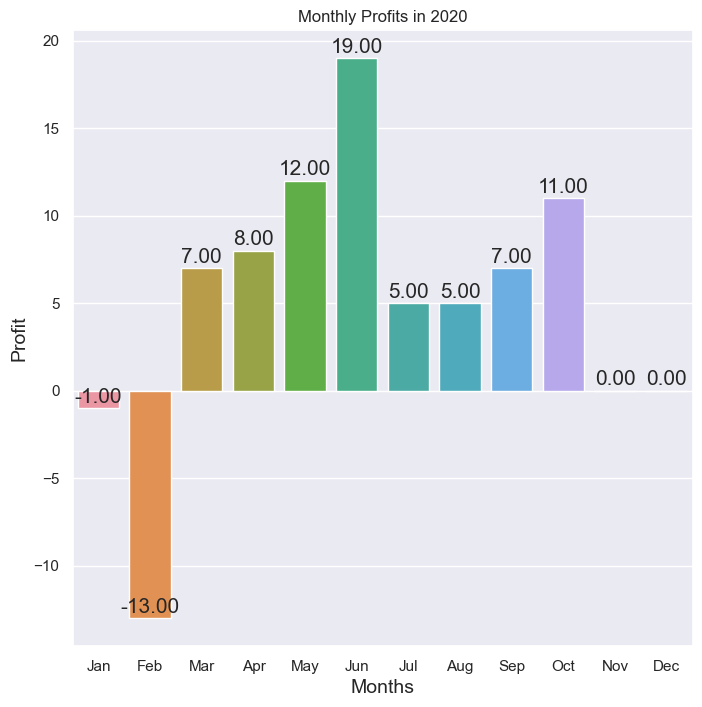

In [10]:
#generate bar plot for monthly profits over 2020

plt.figure(figsize=(8, 8))

plots = sns.barplot(x=list(profit_dict.keys()), y=list(profit_dict.values()))

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'), 
                    (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                size=15, xytext=(0, 8),
                textcoords='offset points')

plt.xlabel("Months", size=14)
plt.ylabel("Profit", size=14)
plt.title("Monthly Profits in 2020")

plt.show()

## Contribution of each drug to total sales

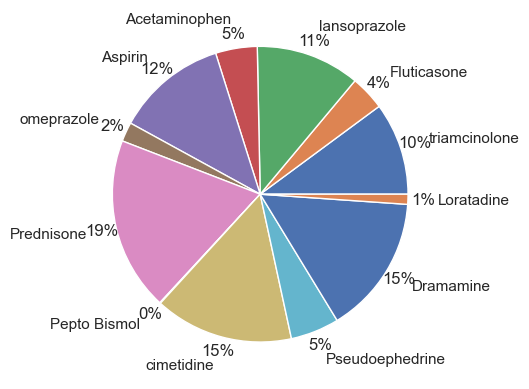

In [72]:
drugNameList = []
salesValue = []

#cursor to run query to obtain total individual sales of all drugs
mycursor = mydb.cursor()
mycursor.execute("SELECT d.Name,SUM(Total_Price) FROM Drugs_in_Orders as dio JOIN Drugs as d ON d.ID = dio.Drugs_ID GROUP BY Drugs_ID;")
myresult = mycursor.fetchall()
mycursor.close()

#store results
for result in myresult:
    drugNameList.append(result[0])
    salesValue.append(result[1])

#function to plot results in a piechart
plt.pie(salesValue, labels = drugNameList,autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
plt.show()

## Difference between listed delivery time and actual delivery time

In [63]:
#query to find eta of order and average delivery time of corresponding vendor
query = """SELECT v.Vendor_ID, v.Average_Shipping_Time_in_days, s.ETA_in_days
FROM Orders as o
JOIN Vendor as v
ON o.Recipient_ID = v.Vendor_ID
JOIN Ships as s
ON o.ID = s.Order_ID
WHERE Recipient_ID LIKE \"V%\";"""

#cursor to run query
mycursor = mydb.cursor()
mycursor.execute(query)
myresult = mycursor.fetchall()
mycursor.close()

vendor = []
averageTime = []
eta = []

#store results
for result in myresult:
    vendor.append(result[0])
    averageTime.append(int(result[1]))
    eta.append(int(result[2]))
    
data = {"Vendor":vendor, "Average Delivery Time (in days)": averageTime, "Actual ETA (in days)": eta}
deliverydifference = pd.DataFrame(data)

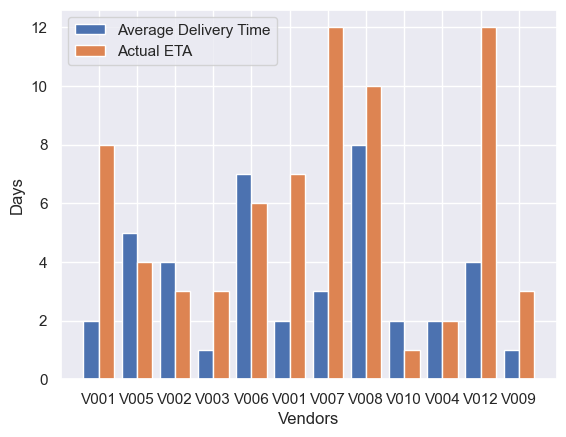

In [71]:
#graph to plot actual eta and average delivery time of each vendor per order
x = np.arange(len(vendor))
plt.bar(x-0.2, averageTime, 0.4) 
plt.bar(x+0.2, eta, 0.4) 
plt.xticks(x,vendor)
plt.xlabel("Vendors")
plt.ylabel("Days")
plt.legend(["Average Delivery Time","Actual ETA"])
plt.show()

# Utility Functions

## Place order

In [6]:
#function to place order

def askwhatOrder():
    chemList = []
    isAvailable = 1
    keepAsking = True
    drugPrice ={}
    drugNameID = {}
    drug = ''
    quantity = ''
    totalVal = 0
    eachTotal = 0
    drugsList = []
    eachDrugPrice = {}
    
    #query to find latest order number
    digitquery = """SELECT ID
    FROM Orders
    ORDER BY ID desc
    LIMIT 1"""
    mydb = mysql.connector.connect(
                      host="localhost",
                      user="root",
                      password="********",
                      database="pharma"
                    )
    mycursor = mydb.cursor()
    mycursor.execute(digitquery)
    myresult = mycursor.fetchall()
    mycursor.close()
    
    #obtain new order number
    for x in myresult:
        digitStr = int(x[0][3:]) + 1

    #take input to place order from a distributor or vendor
    path = input("What orders do you want to place today? Type B for Distributor. Type V for Vendor order placement")
    print("\n")
    
    #place order from a distributor
    if (path == 'B'):
        
        userId = input('Enter the distributor ID: ')
       
        #fetch drug option to choose from
        mycursor = mydb.cursor()
        mycursor.execute("SELECT * FROM Drugs")
        myresult = mycursor.fetchall()
        mycursor.close() 
        
        while (keepAsking):
            print("\nPlease select the drug you want: ")
            for x in myresult:
                drugPrice[x[1]] = x[6]
                drugNameID[x[1]] = x[0]
                print(x[1])
            drug = input("\nEnter the drug you want to order: ")
            quantity = input("\nEnter the quantity you want: ")
            
            #check availability of drug
            mycursor = mydb.cursor()
            mycursor.callproc("get_drug_stock",(drug,quantity))

            for result in mycursor.stored_results():
                res = result.fetchall()
                stock = int(res[0][0])

            mycursor.close() 
            
            #if drug is in stock then calculate total price order and append the drug to the current order
            if(stock >= int(quantity)):
                eachTotal = drugPrice[drug] * int(quantity)
                totalVal = totalVal + eachTotal
                drugsList.append(drug)
                eachDrugPrice[drug] = (eachTotal,quantity)

                decision = input("\nDo you want to buy more drugs? type Yes to continue and No to stop").lower()
                keepAsking = True if decision == 'yes' else False
            else:
                print("The drug you want to order is not available or is less in quantity")
        
        random_month = random.randint(1,12)
        random_date = random.randint(1,28)
           
        #call procedure to insert new order in Orders table
        mycursor = mydb.cursor()
        mycursor.callproc("create_order",(("OD0"+str(digitStr)),datetime.date(2020, random_month, random_date), float(totalVal), userId,))
        mydb.commit()
        
        #for each drug in order insert new record in drugs_in_order table
        for drg in drugsList:
        
            mycursor.callproc("push_drugs_in_order",(("OD0"+str(digitStr)),drugNameID[drg], eachDrugPrice[drg][1], float(eachDrugPrice[drg][0]),))
            mydb.commit()
            
    #place vendor order
    elif (path == 'V'):
        while(keepAsking):
            mycursor = mydb.cursor()
            mycursor.execute("SELECT * FROM Chemicals")
            myresult = mycursor.fetchall()
            mycursor.close()

            #get the chemical id to order
            chemIDName = {}

            print("\nPlease select the chemical you want: ")
            for x in myresult:
                chemIDName[x[0]] = x[1]
                print(x[0],":",x[1])
                
            chem = input("\nEnter the ID of the chemical you want to order: ")

            VendorIDPrice = {}

            #query to find which vendors provide the desired chemical
            query = """SELECT vi.Vendor_ID, v.Name, vi.Price_per_packet 
            FROM Vendor_Inventory AS vi
            JOIN Vendor as v
            ON vi.Vendor_ID = v.Vendor_ID
            WHERE vi.Chemical_ID = \"{}\"""".format(chem)

            mycursor = mydb.cursor()
            mycursor.execute(query)
            myresult = mycursor.fetchall()
            mycursor.close()

            print("\nThe following vendors offer {}".format(chemIDName[chem]))
            for x in myresult:
                print(x[0],x[1],"${} per packet".format(x[2]))
                VendorIDPrice[x[0]] = x[2]

            vendorID = input("\nEnter the ID of the vendor you want to place the order from: ")
            quantity = input("\nEnter the quantity (in 1k packets): ")

            totalVal = VendorIDPrice[vendorID] * int(quantity)

            args = (chem,float(quantity),float(totalVal))
            chemList.append(args)

            cont = input("\nBuy more chemicals?(Yes/No):")
            if cont == "Yes":
                keepAsking = True
            else:
                keepAsking = False

        #compute total chemical value
        totalOrderVal = 0
        for c in chemList:
            totalOrderVal += c[2]
            
        random_month = random.randint(1,12)
        random_date = random.randint(1,28)
    
        #insert new record in Orders table
        mycursor = mydb.cursor()
        mycursor.callproc("create_order",(("OD0"+str(digitStr)),datetime.date(2020, random_month, random_date), float(totalOrderVal), vendorID,))
        mydb.commit()

        #insert new record in chemicals_in_order table
        for c in chemList:
            mycursor.callproc("push_chemicals_in_order",(("OD0"+str(digitStr)),c[0],c[1],c[2]))
            mydb.commit()

In [7]:
askwhatOrder()

What orders do you want to place today? Type B for Distributor. Type V for Vendor order placementB


Enter the distributor ID: B001

Please select the drug you want: 
omeprazole
Aspirin
cimetidine
Acetaminophen
lansoprazole
Fluticasone
bisacodyl
Pseudoephedrine
Pepto Bismol
Loratadine
Dramamine
Prednisone
triamcinolone

Enter the drug you want to order: triamcinolone

Enter the quantity you want: 1

Do you want to buy more drugs? type Yes to continue and No to stopNo


# Get best vendor

In [25]:
#function to find cheapest or fastest vendor

def getBestOption():
    mycursor = mydb.cursor()
    mycursor.execute("SELECT * FROM Chemicals")
    myresult = mycursor.fetchall()
    mycursor.close()

    #insert chemical ID
    chemIDName = {}
    print("Please select the chemical you want: ")
    for x in myresult:
        chemIDName[x[0]] = x[1]
        print(x[0],":",x[1])
    print("\n")
    chem = input("Enter the chemical you want to place an order for: ")
    print(chem)
    x = 2
    sortBy = input("Enter C for the cheapest option or F for the fastest delivery: ").lower()
    
    sqlQuery = "select get_cheapest_vendor(%s)"
    mycursor = mydb.cursor()
    
    #query to find cheapest vendor
    if(sortBy == 'c'):
        sqlQuery     = "select get_cheapest_vendor(%s)"
        mycursor.execute(sqlQuery,(chem,))
        myResults = mycursor.fetchall()
        for result in myResults:
            print(result[0]+ " is the cheapest vendor for this chemical.")
    
    #query to find fastest vendor
    elif(sortBy == 'f'):
        sqlQuery     = "select get_fastest_vendor(%s)"
        mycursor.execute(sqlQuery,(chem,))
        myResults = mycursor.fetchall()
        for result in myResults:
            print(result[0]+ " is the fastest vendor for this chemical.")


In [27]:
getBestOption()

Please select the chemical you want: 
C001 : acetylsalicylic acid
C002 : hypromellose
C003 : mannitol
C004 : N-(4-hydroxyphenyl)acetamide
C005 : povidone
C006 : benzimidazole
C007 : titanium dioxide
C008 : magnesium carbonate
C009 : polyethylene glycol
C010 : hydroxypropyl cellulose
C011 : fluticasone propylate
C012 : magnesium stearate
C013 : Pseudoephedrine hydrochloride
C014 : Loratadine
C015 : bismuth subsalicylate
C016 : silicon dioxide
C017 : prednisolone
C018 : dimenhydrinate
C019 : lactose
C020 : Glycerin
C021 : Isopropyl Palmitate


Enter the chemical you want to place an order for: Glycerin
Glycerin
Enter C for the cheapest option or F for the fastest delivery: F
V001 is the fastest vendor for this chemical.


# View Approvals

In [28]:
#find drug approvals from view - approvals_for_board

mycursor = mydb.cursor()
mycursor.execute("SELECT * FROM approvals_for_board;")
myresult = mycursor.fetchall()
drugNameList = []
approvedList = []

for result in myresult:
    drugNameList.append(result[1])
    approvedList.append(result[2])
    
data = {'Name' : drugNameList, 'Lab Approved' : approvedList}
drugLabResults = pd.DataFrame(data)

In [29]:
drugLabResults

,Name,Lab Approved
0,omeprazole,Yes
1,cimetidine,Pending
2,lansoprazole,Yes
3,Fluticasone,Yes
4,bisacodyl,Yes
5,Pepto Bismol,Yes
6,Dramamine,Yes
7,triamcinolone,Pending


# View top drug sales

In [34]:
#view drugs with highest sales value

mycursor = mydb.cursor()
mycursor.execute("SELECT * FROM top_drug_sales;")
myresult = mycursor.fetchall()
drugNameList = []
PriceList = []

for result in myresult:
    drugNameList.append(result[0])
    PriceList.append(result[1])
    
data = {'Name' : drugNameList, 'Order_Price' : PriceList}
topdrugOrders = pd.DataFrame(data)

In [35]:
topdrugOrders

,Name,Order_Price
0,Dramamine,180000
1,cimetidine,150000
2,Prednisone,90000
3,triamcinolone,84000
4,Prednisone,81000


# View ingredients of a drug

In [43]:
#view ingredients required in a particular drug

drugName = input("Enter the drug name:")

#cursor to call procedure
mycursor = mydb.cursor()
callproc = "CALL get_chemicals_in_drug(\"{}\")".format(drugName)
mycursor.execute(callproc)
myresult = mycursor.fetchall()
mycursor.close()

chemId = []
chemName = []
chemStock = []
chemRatio = []

for result in myresult:
    chemId.append(result[0])
    chemName.append(result[1])
    chemStock.append(result[2])
    chemRatio.append(result[3])
    
data = {"Chemical ID":chemId, "Name":chemName, "Current Stock(in 1k packets)":chemStock, "Mix in Parts":chemRatio}
drugIngredients = pd.DataFrame(data)

Enter the drug name:Aspirin


In [44]:
drugIngredients

,Chemical ID,Name,Current Stock(in 1k packets),Mix in Parts
0,C003,mannitol,5,2
1,C011,fluticasone propylate,25,2
